In [5]:
#inverse kinematics 
# code for the paper
# based on the freely available Freia package and their code
%matplotlib notebook
from time import time
import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)
np.random.seed(1)

no_samples = 100000
samples = np.random.binomial(size=no_samples, n=1, p= 0.5)
x1 = torch.zeros(no_samples,1)
for i in range(no_samples):
    if samples[i] == 0:
        x1[i]  = -1+ torch.randn(1,1)*(1/8)
    else: 
        x1[i]  = 1+ torch.randn(1,1)*(1/8)
x2  = torch.randn(no_samples,1)*0.5
x3  = torch.randn(no_samples,1)*0.5
x4  = torch.randn(no_samples,1)*0.5

y1 = x1 + 0.5*torch.sin(x3-x2)+0.5*torch.sin(x2)+torch.sin(x4-x3-x2)
y2 = 0.5*torch.cos(x3-x2)+0.5*torch.cos(x2)+torch.cos(x4-x3-x2)

In [6]:
x_train = torch.cat((x1,x2,x3,x4),1)
y_train = torch.cat((y1,y2),1)

In [7]:
# found empirically that padding helps to model the multimodality
ndim_tot = 4
ndim_x = 4
ndim_y = 2
ndim_z = 2

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 256), nn.ReLU(),
                         nn.Linear(256, 256), nn.ReLU(),
                         nn.Linear(256,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(7):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)

model.load_state_dict(torch.load('inn.pt'))

<All keys matched successfully>

In [8]:
# Training parameters
n_epochs = 500
batch_size = 3200

lr = 1e-3
#low l2 reg
l2_reg = 8e-6

y_noise_scale = 1e-2
zeros_noise_scale = 1e-4

# relative weighting of losses:
lambd_predict = 150. 
lambd_latent = 10.
lambd_rev = 25. 
lambd_recon = 10.
loss_ramp = True

pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05,0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)



def MMD_matrix_multiscale(x, y, widths_exponents):
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = torch.clamp(rx.t() + rx - 2.*xx, 0, np.inf)
    dyy = torch.clamp(ry.t() + ry - 2.*yy, 0, np.inf)
    dxy = torch.clamp(rx.t() + ry - 2.*xy, 0, np.inf)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for C,a in widths_exponents:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a

    return XX + YY - 2.*XY


def f(x):
    y1 = x[:,0] + 0.5*torch.sin(x[:,2]-x[:,1])+0.5*torch.sin(x[:,1])+torch.sin(x[:,3]-x[:,2]-x[:,1])
    y2 = 0.5*torch.cos(x[:,2]-x[:,1])+0.5*torch.cos(x[:,1])+torch.cos(x[:,3]-x[:,2]-x[:,1])
    y1 = y1.view(1,1)
    y2 = y2.view(1,1)
    return torch.cat((y1,y2),1)

def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_matrix_multiscale
loss_latent = MMD_matrix_multiscale
loss_fit = fit

In [9]:
def train(i_epoch=0):
    model.train()

    l_tot = 0    
    
    t_start = time()
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.  
    if loss_ramp:
        loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    else:
        loss_factor = 1.
    perm = torch.randperm(len(x_train))
    perm = perm[0:batch_size]
   
    x = x_train[perm]
    y = y_train[perm]
    x, y = x.to(device), y.to(device)
        
    y_clean = y.clone()
    pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
    pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

    y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

    x, y = (torch.cat((x, pad_x),  dim=1),
            torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                        dim=1))
        

    optimizer.zero_grad()

    # Forward step:

    output = model(x)

    # Shorten output, and remove gradients wrt y, for latent loss
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])
    output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

    l += lambd_latent * torch.mean(loss_latent(output_block_grad, y_short,[(0.2, 2), (1.5, 2), (3.0, 2)]))
    l_tot += l.data.item()

    l.backward()

    # Backward step:
    pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
    y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

    orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
    y_rev = torch.cat((orig_z_perturbed, pad_yz, output.data[:, -ndim_y:]+ y_noise_scale *
                            torch.randn(batch_size, ndim_y, device=device)), dim=1)
    y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)
        
    output_rev = model(y_rev, rev=True)
        
      
    output_rev_rand = model(y_rev_rand, rev=True)

    l_rev = (
        lambd_rev
        * loss_factor
        * torch.mean(loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x],[(1.183, 0.2), (1.183, 1.0), (1.183, 2.0)]))
        )

    l_rev += lambd_recon * loss_fit(output_rev, x)
    l_tot += l_rev.data.item()

    l_rev.backward()

    for p in model.parameters():
         p.grad.data.clamp_(-15.00, 15.00)

    optimizer.step()

    return l_tot

In [14]:
for i in range(n_epochs):
    train_loss = train(i)
    if i%100 ==0:
        print('TRAIN LOSS at epoch '+str(i)+': '+str(train_loss))


TRAIN LOSS at epoch 0: 459.7533527389169
TRAIN LOSS at epoch 100: 3.9144226759672165
TRAIN LOSS at epoch 200: 1.7964605391025543
TRAIN LOSS at epoch 300: 2.4307900816202164
TRAIN LOSS at epoch 400: 2.3013584315776825


In [41]:
y = torch.zeros(100,2)
y[:,0] = 0.5
y[:,1] = 1.5
z = torch.randn(100,2)
inp = torch.cat((z, y),1).to(device)

out = model(inp, rev = True).cpu().detach().numpy()
# test the error 

pts = []
for i in range(len(out)):
    seq = np.zeros((4,2))
    seq[0][0] = out[i,0]
    seq[0][1] = 0
    seq[1][0] = out[i,0]+0.5*np.sin(out[i,1])
    seq[1][1] = 0.5*np.cos(out[i,1])
    seq[2][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])
    seq[2][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])
    seq[3][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])+np.sin(out[i,3]-out[i,2]-out[i,1])
    seq[3][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])+np.cos(out[i,3]-out[i,2]-out[i,1])
    pts.append(seq)
    
    


<IPython.core.display.Javascript object>


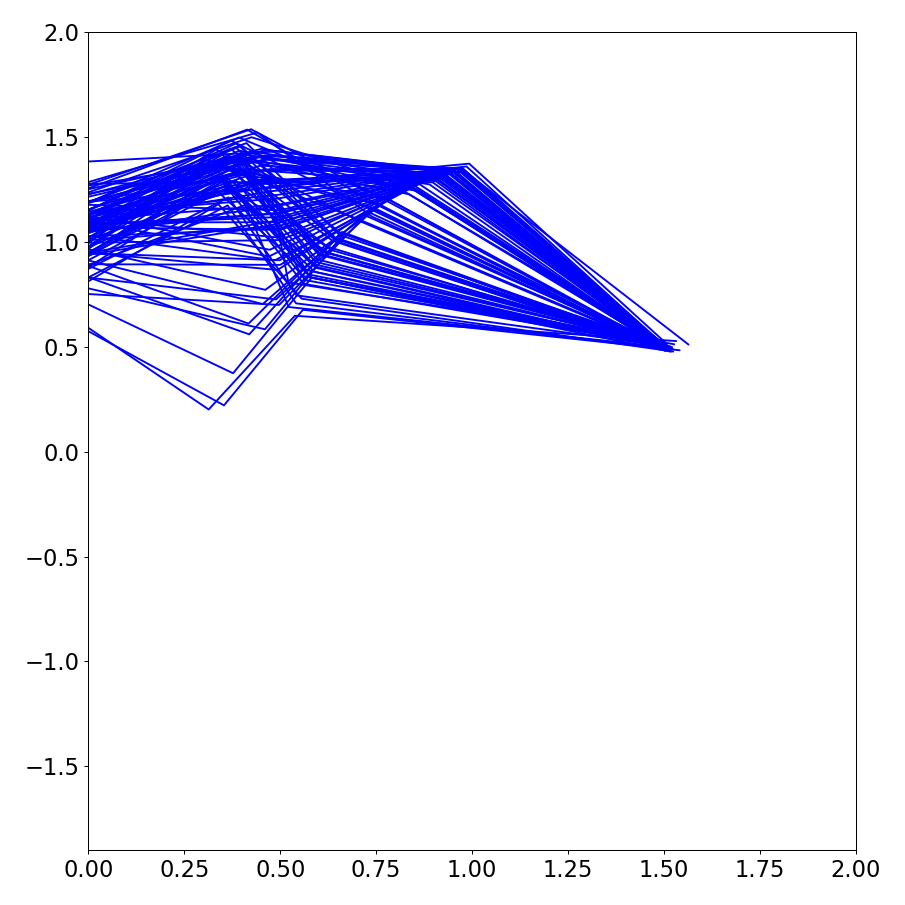

In [42]:
fig = plt.figure(figsize=(10,10), dpi = 80)
for i in range(len(pts)):
    plt.plot(pts[i][:,1],pts[i][:,0], 'b')
plt.rcParams.update({'font.size': 18})
plt.ylim(-1.9, 2)
plt.xlim(0,2)
plt.show()
plt.tight_layout()
fig.savefig("inn_2.png")

In [39]:
y = torch.zeros(100,2, device = device)
y[:,0] = 0.
y[:,1] = 1.5
z = torch.randn(100,2, device = device)
inp = torch.cat((z, y),1).to(device)

out = model(inp, rev = True).cpu().detach().numpy()
# test the error 

pts = []
for i in range(len(out)):
    seq = np.zeros((4,2))
    seq[0][0] = out[i,0]
    seq[0][1] = 0
    seq[1][0] = out[i,0]+0.5*np.sin(out[i,1])
    seq[1][1] = 0.5*np.cos(out[i,1])
    seq[2][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])
    seq[2][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])
    seq[3][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])+np.sin(out[i,3]-out[i,2]-out[i,1])
    seq[3][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])+np.cos(out[i,3]-out[i,2]-out[i,1])
    pts.append(seq)
    
    

<IPython.core.display.Javascript object>


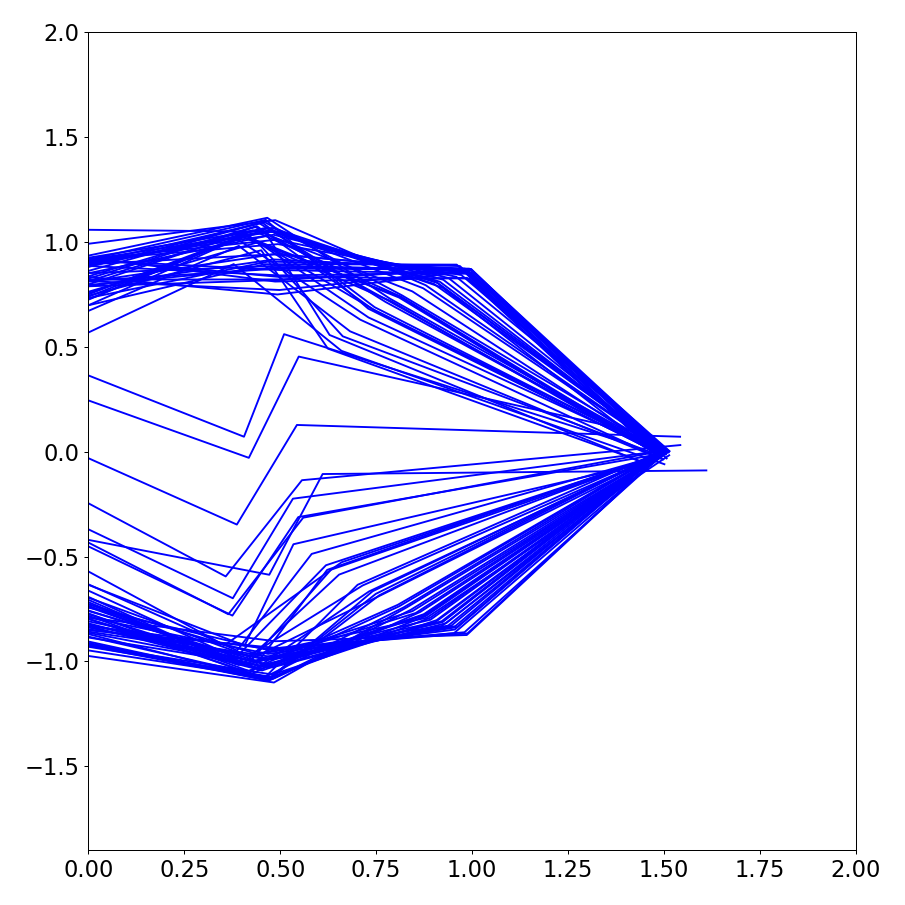

In [40]:
fig = plt.figure(figsize=(10,10), dpi  = 80)
for i in range(len(pts)):
    plt.plot(pts[i][:,1],pts[i][:,0], 'b')
plt.rcParams.update({'font.size': 18})
plt.ylim(-1.9, 2)

plt.xlim(0,2)
plt.show()
plt.tight_layout()

fig.savefig("inn_1.png")

In [15]:
n_epochs = 1800
l2_reg = 1e-7

loss_ramp = False


In [16]:
lrs = [8e-4,4e-4,1e-4,5e-5]
for lr in lrs:
    for g in optimizer.param_groups:
        g['lr'] = lr
        g['weight_decay'] = l2_reg 

    for i in range(n_epochs):
        train_loss = train(i)
        if i%100 ==0:
            print('TRAIN LOSS at epoch '+str(i)+': '+str(train_loss))

TRAIN LOSS at epoch 0: 0.9923252463340759
TRAIN LOSS at epoch 100: 1.1635947525501251
TRAIN LOSS at epoch 200: 0.6216225326061249
TRAIN LOSS at epoch 300: 0.5246737450361252
TRAIN LOSS at epoch 400: 0.7577119767665863
TRAIN LOSS at epoch 500: 0.4260031431913376
TRAIN LOSS at epoch 600: 0.4451170936226845
TRAIN LOSS at epoch 700: 0.44931164383888245
TRAIN LOSS at epoch 800: 0.45201897621154785
TRAIN LOSS at epoch 900: 0.6876052021980286
TRAIN LOSS at epoch 1000: 0.5633369833230972
TRAIN LOSS at epoch 1100: 0.5073779672384262
TRAIN LOSS at epoch 1200: 0.6566537022590637
TRAIN LOSS at epoch 1300: 0.5360945612192154
TRAIN LOSS at epoch 1400: 0.4955471605062485
TRAIN LOSS at epoch 1500: 0.5546263307332993
TRAIN LOSS at epoch 1600: 0.47366105020046234
TRAIN LOSS at epoch 1700: 0.42211927473545074
TRAIN LOSS at epoch 0: 0.38271190226078033
TRAIN LOSS at epoch 100: 0.2900586351752281
TRAIN LOSS at epoch 200: 0.2819715440273285
TRAIN LOSS at epoch 300: 0.2380533292889595
TRAIN LOSS at epoch 400

In [19]:
tens = np.load('rejection_samples_multi.npy', allow_pickle = True)

y = torch.zeros(len(tens),2, device = device)
y[:,0] = 0.
y[:,1] = 1.5
z = torch.randn(len(tens),2, device = device)

inp = torch.cat((z,y),1).to(device)
out = model(inp, rev = True)

tens = torch.tensor(tens, device = device).float()

s = 0 
for j in range(len(out)):
    # resimulation error
    fx = f(out[j].view(1,4))[0]
    s += torch.sum((fx-torch.tensor([0.,1.5], device = device))**2)  
print(s/len(out))
    
print(MMD_multiscale(tens,out))

tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)


In [21]:
tens = np.load('rejection_samples_uni.npy', allow_pickle = True)

y = torch.zeros(len(tens),2, device = device)
y[:,0] = 0.5
y[:,1] = 1.5
z = torch.randn(len(tens),2, device = device)

inp = torch.cat((z,y),1).to(device)
out = model(inp, rev = True)[:,(0,1,2,3)]
tens = torch.tensor(tens, device = device).float()

s = 0 
for j in range(len(out)):
    # resimulation error
    fx = f(out[j].view(1,4))[0]
    s += torch.sum((fx-torch.tensor([0.5,1.5], device = device))**2)  
print(s/len(out))
print(MMD_multiscale(tens,out))

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)


In [26]:
torch.save(model.state_dict(), 'INN.pt')